Traning for fold: 1

*******************Initial Weights***************************
1  Layer
[{'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614, 0.2550690257394217, 0.49543508709194095, 0.4494910647887381, 0.651592972722763, 0.7887233511355132, 0.0938595867742349, 0.02834747652200631, 0.8357651039198697]}, {'weights': [0.43276706790505337, 0.762280082457942, 0.0021060533511106927, 0.4453871940548014, 0.7215400323407826, 0.22876222127045265, 0.9452706955539223, 0.9014274576114836, 0.030589983033553536, 0.0254458609934608, 0.5414124727934966]}, {'weights': [0.9391491627785106, 0.38120423768821243, 0.21659939713061338, 0.4221165755827173, 0.029040787574867943, 0.22169166627303505, 0.43788759365057206, 0.49581224138185065, 0.23308445025757263, 0.2308665415409843, 0.2187810373376886]}, {'weights': [0.4596034657377336, 0.28978161459048557, 0.021489705265908876, 0.8375779756625729, 0.5564543226524334, 0.6422943629324456, 0.1859062658947177, 0.9925434121760651, 0.859946528

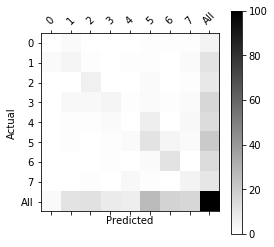

In [1]:
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Split Data in train and holdout set
def split_data(df):
    df=pd.DataFrame(df)
    training_data, holdout_data = np.split(df,[int(0.6 * len(df))])
    training_data=training_data.reset_index(drop=True)
    holdout_data=holdout_data.reset_index(drop=True)
    traing_data=list(list(x) for x in zip(*(training_data[x].values.tolist() for x in training_data.columns)))
    holdout_data=list(list(x) for x in zip(*(holdout_data[x].values.tolist() for x in holdout_data.columns)))
    return traing_data,holdout_data

# Load a file
bad_chars = ['(', ')']
def load_data(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            row = ''.join(i for i in row[0] if not i in bad_chars)
            row = row.split(" ")
            dataset.append(row[1:])
    for i in range(len(dataset[0])-1):
        str_column_to_float(dataset, i)
    # convert class column to integers
    str_column_to_int(dataset, len(dataset[0])-1)
    # normalize input variables
    minmax = dataset_minmax(dataset)
    normalize_dataset(dataset, minmax)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(train_set,test_set, algorithm, n_folds, *args):
    scores = list()
    epochs=list()
    maxaccuracy=float('-inf')
    for fold in range(n_folds):
        print("Traning for fold:",fold+1)
        predicted,network,epoch = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in test_set]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
        epochs.append(epoch)
        if accuracy>maxaccuracy:
            maxaccuracy=accuracy
            finalNetwork=network
    return scores,network,epochs


#Validtion on validation set 
def validation(validation_set,network):
    scores = list()
    predictions = list()
    for row in validation_set:
        prediction = predict(network, row)
        predictions.append(prediction)
    actual = [row[-1] for row in validation_set]
    accuracy = accuracy_metric(actual, predictions)
    scores.append(accuracy)
    return scores,actual,predictions

# Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

# Transfer neuron activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

# Forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

# Calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# Update network weights with error
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']

# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_outputs):
    epoch=1
    while True:
        sum_error=0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        #print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
        epoch+=1
        if sum_error<11:
            break
    return epoch
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

# Make a prediction with a network
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = initialize_network(10, n_hidden, n_outputs)
    print("\n*******************Initial Weights***************************")
    count=1
    for layer in network:
        print(count," Layer")
        count+=1
        print(layer)
    epoch=train_network(network, train, l_rate, n_outputs)
    print("\n**********************Final Weights**************************")
    count=1
    for layer in network:
        print(count," Layer")
        count+=1
        print(layer)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions),network,epoch

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

# Test Backprop on Seeds dataset
seed(1)
# load and prepare data
filename = '550-01-dataset1.txt'
dataset = load_data(filename)

# evaluate algorithm
n_folds = 2
l_rate = 0.3
n_hidden = 5

training_data,holdout_data=split_data(dataset)

scores,network,epochs = evaluate_algorithm(training_data,holdout_data, back_propagation, n_folds, l_rate, n_hidden)
print("\nHoldOut Set ")
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))
print('Epochs: %s' % epochs)
print('Epochs Avg: %.3f' % (sum(epochs)/float(len(epochs))))

validation_data=load_data('550-01-dataset2.txt')
scores,actual,predicted=validation(validation_data,network)
actual = pd.Series(actual, name='Actual')
predicted = pd.Series(predicted, name='Predicted')
df_confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("\nValidation Set ")
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

print("Condusion Matrix")
df_confusion.head()
plot_confusion_matrix(df_confusion)